In [87]:
'''PACKAGE IMPORTS'''
#For data analysis
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from matplotlib.gridspec import GridSpec
import numpy as np
import seaborn as sns
import scipy
import xarray as xr
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime as dt

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import grangercausalitytests

from scipy.signal import find_peaks
from scipy.stats import kendalltau
from scipy.interpolate import splrep, BSpline

from functions import *

In [2]:
'''Import Data Links'''
import_path = "./Cleaned Data/"
import_path_raw = "./Raw Data/"
fig_savepath = '../Figures/'

In [3]:
'''Import Data'''
#Measured and Modelled Snow and SWE data
snow = pd.read_csv(import_path + 'modelledSnowmelt.csv', 
                    parse_dates = ['Date'])

#Import cleaned soil moisture data
soilM = pd.read_csv(import_path + '01_cleanedsensordata.csv', 
                    parse_dates = ['DateTime'],  
                    index_col = 'Unnamed: 0')

#Import Soil Frost Data
frost = pd.read_csv('./Cleaned Data/2023frost_data.csv', 
                        parse_dates = ['DATE'])

In [5]:
#Merge soil moisture and snowmelt data by date and site
soilMelt_data = pd.merge(soilM[['DateTime', 'SensorName', 'SoilMoist_15cm', 'SoilMoist_30cm', 'SoilMoist_45cm']],
                    snow[['Date', 'stakes', 'Melt_cm_modelled']],
                    left_on = ['DateTime', 'SensorName'], right_on = ['Date', 'stakes'], how = 'outer')

#Calculate deltaSoilM -- change in storage
soilMelt_data['dSoilMoist_15cm'] = soilMelt_data.SoilMoist_15cm.diff().fillna(0)
soilMelt_data['dSoilMoist_30cm'] = soilMelt_data.SoilMoist_30cm.diff().fillna(0)
soilMelt_data['dSoilMoist_45cm'] = soilMelt_data.SoilMoist_45cm.diff().fillna(0)

#Look only at the spring melt season
soilMelt_data = soilMelt_data[(soilMelt_data.Date.dt.year == 2023) & (soilMelt_data.Date.dt.month > 2)]

## Causality Analysis


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8041  , p=0.0299  , df_denom=149, df_num=1
ssr based chi2 test:   chi2=4.9008  , p=0.0268  , df=1
likelihood ratio test: chi2=4.8235  , p=0.0281  , df=1
parameter F test:         F=4.8041  , p=0.0299  , df_denom=149, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.4909  , p=0.0128  , df_denom=146, df_num=2
ssr based chi2 test:   chi2=9.2895  , p=0.0096  , df=2
likelihood ratio test: chi2=9.0149  , p=0.0110  , df=2
parameter F test:         F=4.4909  , p=0.0128  , df_denom=146, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.3881  , p=0.0055  , df_denom=143, df_num=3
ssr based chi2 test:   chi2=13.8087 , p=0.0032  , df=3
likelihood ratio test: chi2=13.2096 , p=0.0042  , df=3
parameter F test:         F=4.3881  , p=0.0055  , df_denom=143, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8643  , p=0.0256  

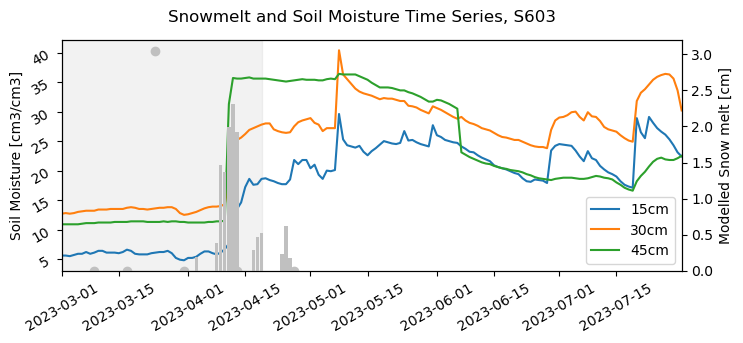

C:\Users\marie\AppData\Local\Temp\ipykernel_37256\2173633968.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 15, 30, 45])


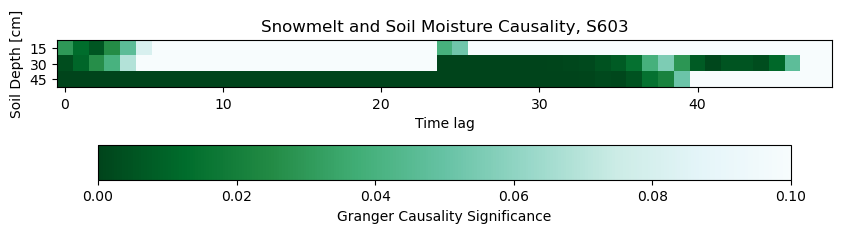


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7124  , p=0.1927  , df_denom=149, df_num=1
ssr based chi2 test:   chi2=1.7469  , p=0.1863  , df=1
likelihood ratio test: chi2=1.7369  , p=0.1875  , df=1
parameter F test:         F=1.7124  , p=0.1927  , df_denom=149, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0662  , p=0.1304  , df_denom=146, df_num=2
ssr based chi2 test:   chi2=4.2738  , p=0.1180  , df=2
likelihood ratio test: chi2=4.2145  , p=0.1216  , df=2
parameter F test:         F=2.0662  , p=0.1304  , df_denom=146, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1113  , p=0.1014  , df_denom=143, df_num=3
ssr based chi2 test:   chi2=6.6439  , p=0.0842  , df=3
likelihood ratio test: chi2=6.5009  , p=0.0896  , df=3
parameter F test:         F=2.1113  , p=0.1014  , df_denom=143, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.1753  , p=0.0749  

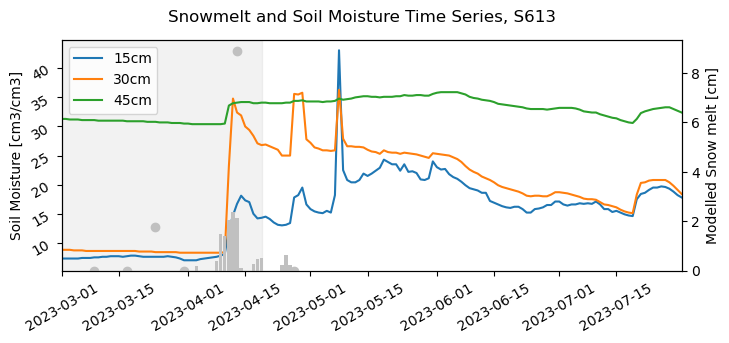

C:\Users\marie\AppData\Local\Temp\ipykernel_37256\2173633968.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 15, 30, 45])


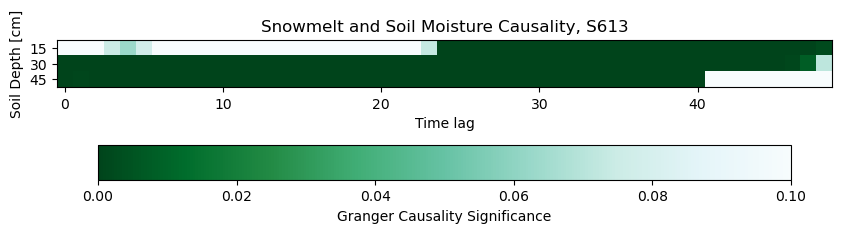


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=30.1868 , p=0.0000  , df_denom=149, df_num=1
ssr based chi2 test:   chi2=30.7946 , p=0.0000  , df=1
likelihood ratio test: chi2=28.0414 , p=0.0000  , df=1
parameter F test:         F=30.1868 , p=0.0000  , df_denom=149, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=17.3380 , p=0.0000  , df_denom=146, df_num=2
ssr based chi2 test:   chi2=35.8635 , p=0.0000  , df=2
likelihood ratio test: chi2=32.1779 , p=0.0000  , df=2
parameter F test:         F=17.3380 , p=0.0000  , df_denom=146, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=12.4453 , p=0.0000  , df_denom=143, df_num=3
ssr based chi2 test:   chi2=39.1634 , p=0.0000  , df=3
likelihood ratio test: chi2=34.7964 , p=0.0000  , df=3
parameter F test:         F=12.4453 , p=0.0000  , df_denom=143, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=11.9076 , p=0.0000  

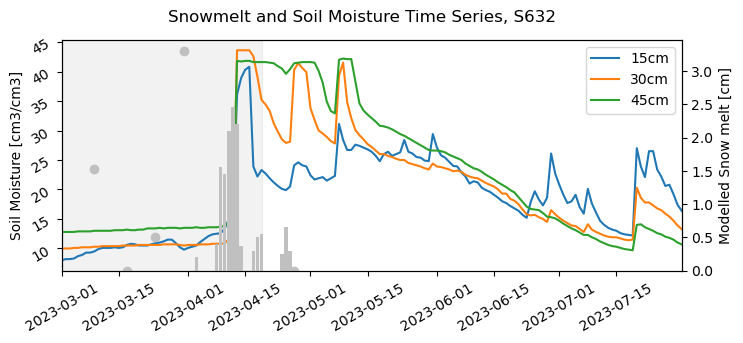

C:\Users\marie\AppData\Local\Temp\ipykernel_37256\2173633968.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 15, 30, 45])


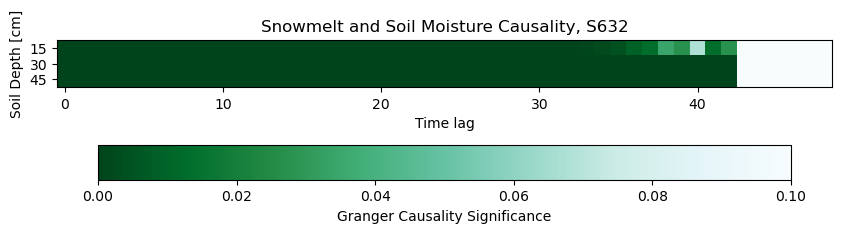


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5830  , p=0.2103  , df_denom=149, df_num=1
ssr based chi2 test:   chi2=1.6149  , p=0.2038  , df=1
likelihood ratio test: chi2=1.6063  , p=0.2050  , df=1
parameter F test:         F=1.5830  , p=0.2103  , df_denom=149, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.4121  , p=0.0932  , df_denom=146, df_num=2
ssr based chi2 test:   chi2=4.9895  , p=0.0825  , df=2
likelihood ratio test: chi2=4.9088  , p=0.0859  , df=2
parameter F test:         F=2.4121  , p=0.0932  , df_denom=146, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7138  , p=0.1668  , df_denom=143, df_num=3
ssr based chi2 test:   chi2=5.3932  , p=0.1452  , df=3
likelihood ratio test: chi2=5.2985  , p=0.1512  , df=3
parameter F test:         F=1.7138  , p=0.1668  , df_denom=143, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3051  , p=0.2711  

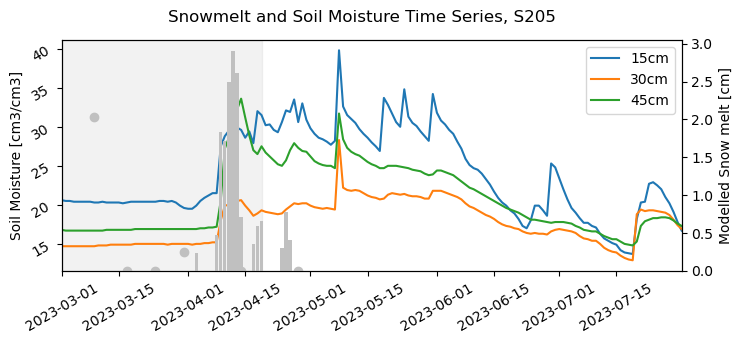

C:\Users\marie\AppData\Local\Temp\ipykernel_37256\2173633968.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 15, 30, 45])


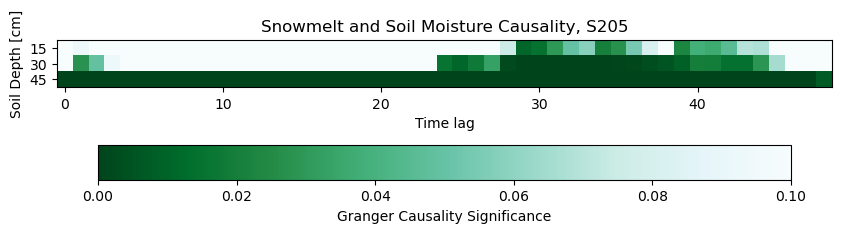


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3810  , p=0.5380  , df_denom=149, df_num=1
ssr based chi2 test:   chi2=0.3887  , p=0.5330  , df=1
likelihood ratio test: chi2=0.3882  , p=0.5332  , df=1
parameter F test:         F=0.3810  , p=0.5380  , df_denom=149, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3957  , p=0.6739  , df_denom=146, df_num=2
ssr based chi2 test:   chi2=0.8185  , p=0.6641  , df=2
likelihood ratio test: chi2=0.8163  , p=0.6649  , df=2
parameter F test:         F=0.3957  , p=0.6739  , df_denom=146, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0861  , p=0.3571  , df_denom=143, df_num=3
ssr based chi2 test:   chi2=3.4178  , p=0.3316  , df=3
likelihood ratio test: chi2=3.3795  , p=0.3367  , df=3
parameter F test:         F=1.0861  , p=0.3571  , df_denom=143, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9398  , p=0.4429  

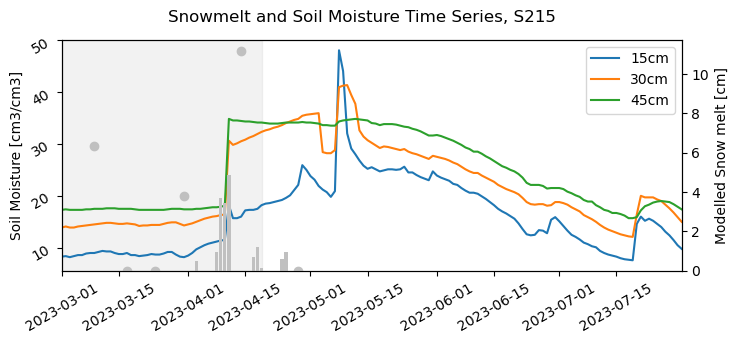

C:\Users\marie\AppData\Local\Temp\ipykernel_37256\2173633968.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 15, 30, 45])


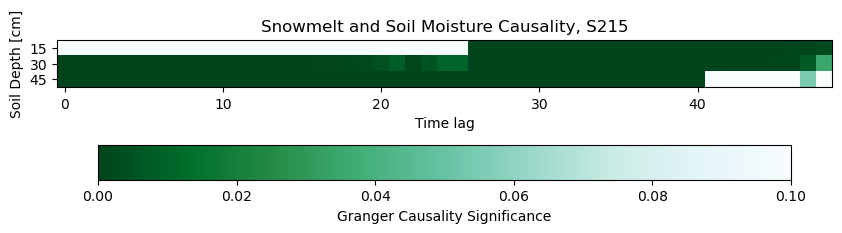


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.5327 , p=0.0002  , df_denom=149, df_num=1
ssr based chi2 test:   chi2=14.8253 , p=0.0001  , df=1
likelihood ratio test: chi2=14.1461 , p=0.0002  , df=1
parameter F test:         F=14.5327 , p=0.0002  , df_denom=149, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.1500  , p=0.0027  , df_denom=146, df_num=2
ssr based chi2 test:   chi2=12.7213 , p=0.0017  , df=2
likelihood ratio test: chi2=12.2138 , p=0.0022  , df=2
parameter F test:         F=6.1500  , p=0.0027  , df_denom=146, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.4525  , p=0.0004  , df_denom=143, df_num=3
ssr based chi2 test:   chi2=20.3052 , p=0.0001  , df=3
likelihood ratio test: chi2=19.0435 , p=0.0003  , df=3
parameter F test:         F=6.4525  , p=0.0004  , df_denom=143, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.1989  , p=0.0001  

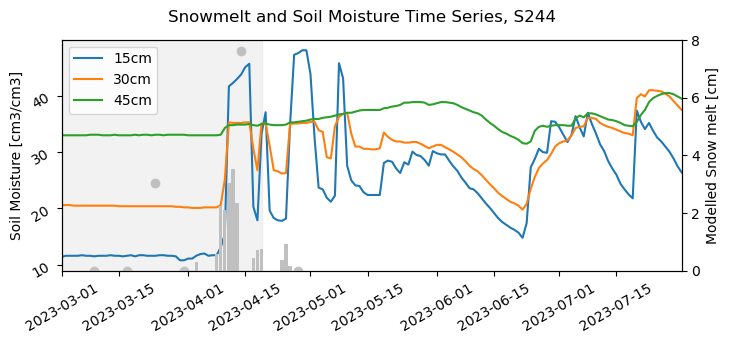

C:\Users\marie\AppData\Local\Temp\ipykernel_37256\2173633968.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 15, 30, 45])


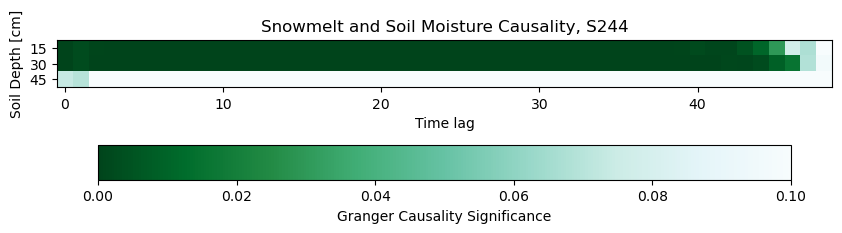


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4899  , p=0.4851  , df_denom=149, df_num=1
ssr based chi2 test:   chi2=0.4998  , p=0.4796  , df=1
likelihood ratio test: chi2=0.4989  , p=0.4800  , df=1
parameter F test:         F=0.4899  , p=0.4851  , df_denom=149, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4042  , p=0.6682  , df_denom=146, df_num=2
ssr based chi2 test:   chi2=0.8362  , p=0.6583  , df=2
likelihood ratio test: chi2=0.8338  , p=0.6591  , df=2
parameter F test:         F=0.4042  , p=0.6682  , df_denom=146, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6083  , p=0.6106  , df_denom=143, df_num=3
ssr based chi2 test:   chi2=1.9143  , p=0.5904  , df=3
likelihood ratio test: chi2=1.9022  , p=0.5930  , df=3
parameter F test:         F=0.6083  , p=0.6106  , df_denom=143, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4958  , p=0.7388  

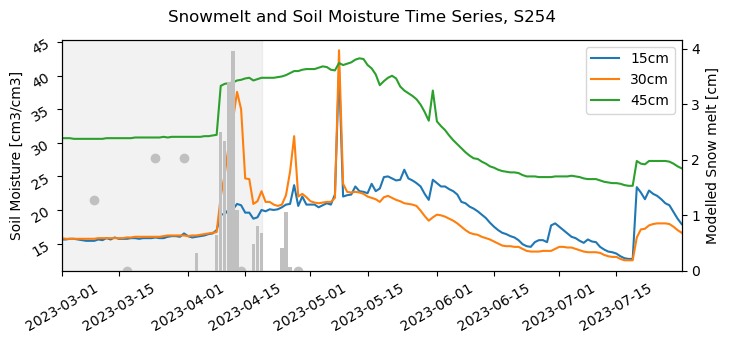

C:\Users\marie\AppData\Local\Temp\ipykernel_37256\2173633968.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 15, 30, 45])


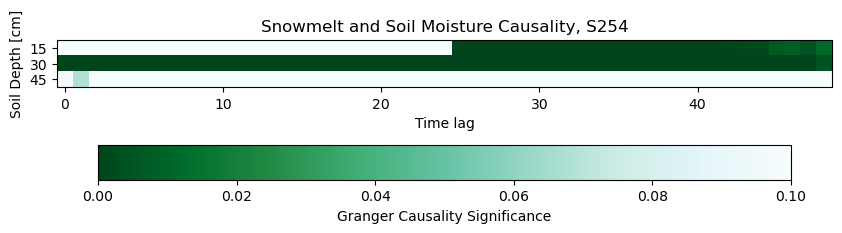

In [22]:
for site in ['S603', 'S613', 'S632', 'S205', 'S215', 'S244', 'S254']:
    #Run causality test
    lags = 49
    tempData = soilMelt_data[soilMelt_data.stakes == site]
    gcause_test15 = grangercausalitytests(tempData[['SoilMoist_15cm', 'Melt_cm_modelled']], maxlag=lags)
    gcause_test30 = grangercausalitytests(tempData[['SoilMoist_30cm', 'Melt_cm_modelled']], maxlag=lags)
    gcause_test45 = grangercausalitytests(tempData[['SoilMoist_45cm', 'Melt_cm_modelled']], maxlag=lags)

    #Manipuclate causality results into matrix for plotting
    resultsMat = np.zeros([3, lags])

    #Separate out depths
    for i in range(0, lags):
        resultsMat[0][i] = gcause_test15[i+1][0]['ssr_ftest'][1]
        resultsMat[1][i] = gcause_test30[i+1][0]['ssr_ftest'][1]
        resultsMat[2][i] = gcause_test45[i+1][0]['ssr_ftest'][1]

    #Plot Time Series
    fig, ax = plt.subplots(1, 1, figsize = (8, 3))

    ax.plot(tempData.DateTime, tempData.SoilMoist_15cm, label = '15cm')
    ax.plot(tempData.DateTime, tempData.SoilMoist_30cm, label = '30cm')
    ax.plot(tempData.DateTime, tempData.SoilMoist_45cm, label = '45cm')
    ax.axvspan(min(tempData.DateTime), min(tempData.DateTime) + dt.timedelta(lags), alpha=0.2, color='silver')
    ax.set_ylabel('Soil Moisture [cm3/cm3]')
    ax.set_xlim(min(tempData.DateTime), max(tempData.DateTime))
    ax.tick_params(rotation = 30)
    ax.legend()

    ax2 = plt.twinx(ax)
    ax2.bar(tempData.DateTime, tempData.Melt_cm_modelled, color = 'silver')
    #ax2.scatter(tempData.DateTime, tempData.Melt_cm_measured, color = 'silver')
    ax2.set_ylabel('Modelled Snow melt [cm]')
    plt.suptitle('Snowmelt and Soil Moisture Time Series, ' + site)
    plt.savefig(fig_savepath + 'soilPlots/soilMoist_snowMelt/timeseries_' + site + '.pdf', bbox_inches = 'tight')
    plt.show()

    #Plot lag correlation matrix
    fig, ax = plt.subplots(1, 1, figsize = (10, 3))
    a = ax.matshow(resultsMat,
                cmap = 'BuGn_r', vmin = 0, vmax = 0.10)

    ax.set_xlabel('Time lag')
    ax.set_ylabel('Soil Depth [cm]')
    ax.set_yticklabels([0, 15, 30, 45])
    ax.xaxis.set_ticks_position('bottom')
    fig.colorbar(a, ax=ax, location = 'bottom', label = 'Granger Causality Significance', pad = 0.25)
    plt.title('Snowmelt and Soil Moisture Causality, ' + site)
    plt.savefig(fig_savepath + 'soilPlots/soilMoist_snowMelt/causality_' + site + '.pdf', bbox_inches = 'tight')
    plt.show()

## Site Specific Soil Analysis

### Initial Plotting

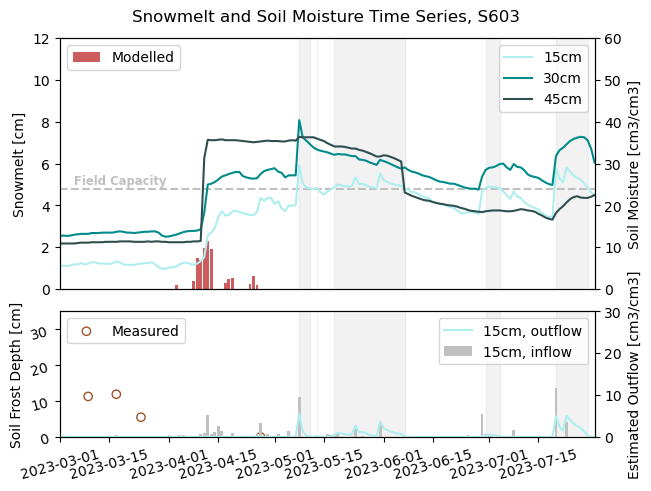

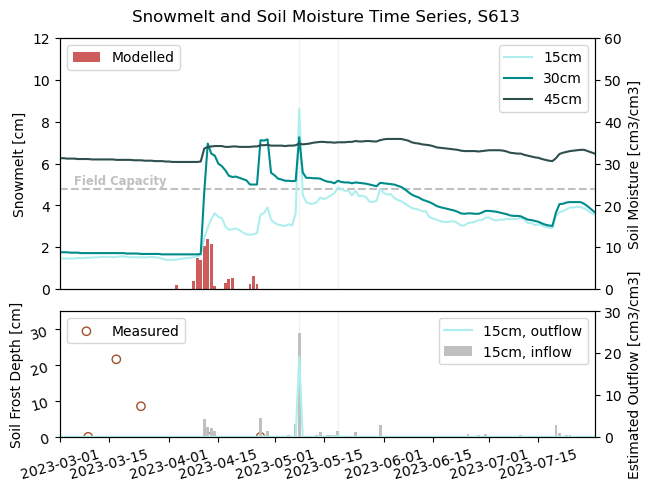

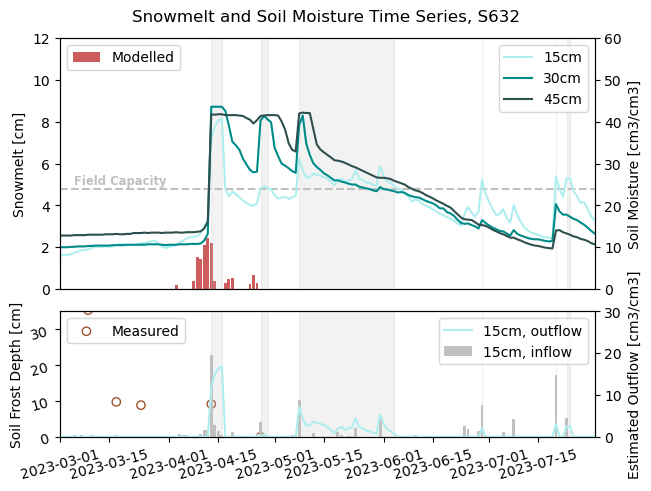

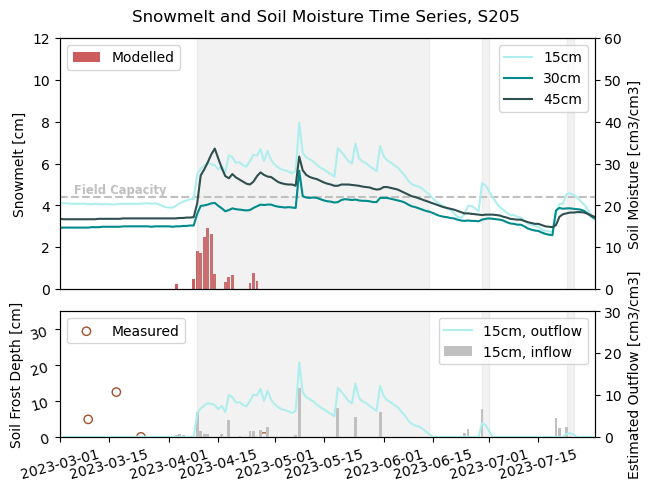

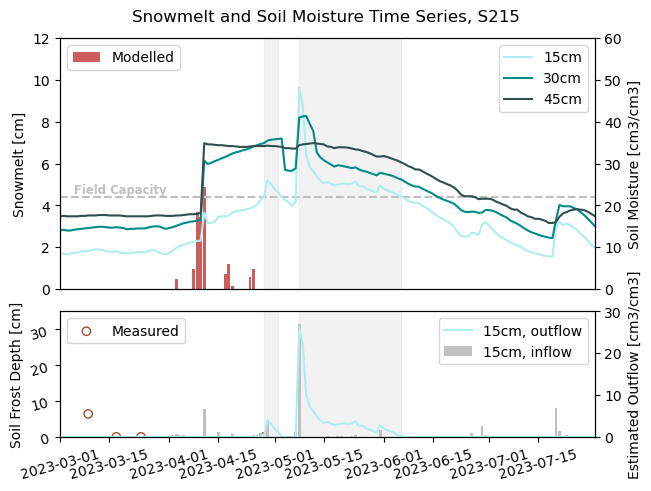

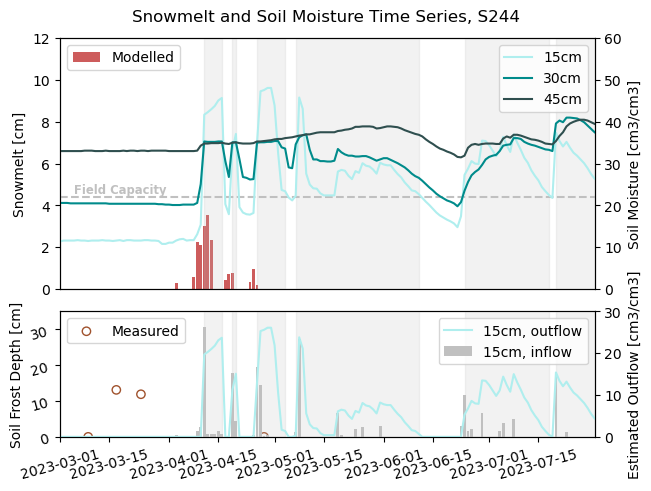

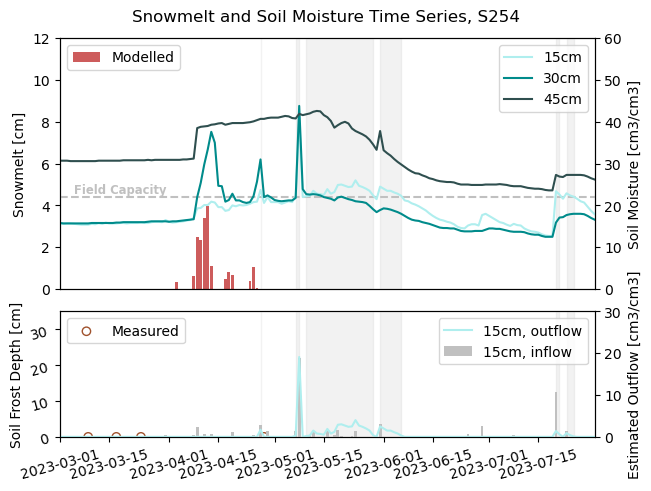

In [6]:
#Select site
for site in ['S603', 'S613', 'S632', 'S205', 'S215', 'S244', 'S254']:

    #Select field capacity 
    if site[0:2] == 'S2':
        fc = 22
    else:
        fc = 24

    tempData = soilMelt_data[soilMelt_data.stakes == site]
    tempFrost = frost[frost['STAKE NO'] == site]

    #merge
    tempData = tempData.merge(tempFrost, left_on = 'DateTime', right_on = 'DATE', how = 'outer')
    tempData['frost_depth'] = tempData['FROST.1'].fillna(method='ffill')

    fig = plt.figure(layout="constrained")
    gs = GridSpec(3, 1, figure=fig)

    #Top plot is soil moisture and melt -- shaded by field capacity
    ax1 = fig.add_subplot(gs[0:2, :])
    ax1.bar(tempData.DateTime, tempData.Melt_cm_modelled, color = 'indianred', label = 'Modelled')
    #ax1.scatter(tempData.DateTime, tempData.Melt_cm_measured, color = 'indianred', marker = 'o', facecolor = 'none', label = 'Measured')
    ax1.tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
    ax1.set_ylim(0, 12)
    ax1.legend(loc = 'upper left')

    ax12 = plt.twinx(ax1)
    ax12.axhline(y = fc, zorder = -1, color = 'silver', linestyle = '--')
    ax12.fill_between(tempData.DateTime, 60, where = tempData.SoilMoist_15cm > fc, alpha=0.2, color='silver')
    ax12.text(pd.to_datetime('2023-03-05'), fc + 1, 'Field Capacity', color = 'silver', fontsize = 'small', fontweight = 'demi')
    ax12.plot(tempData.DateTime, tempData.SoilMoist_15cm, label = '15cm', color = 'paleturquoise')
    ax12.plot(tempData.DateTime, tempData.SoilMoist_30cm, label = '30cm', color = 'darkcyan')
    ax12.plot(tempData.DateTime, tempData.SoilMoist_45cm, label = '45cm', color = 'darkslategrey')
    ax12.set_ylabel('Soil Moisture [cm3/cm3]')
    ax12.set_xlim(min(tempData.DateTime), max(tempData.DateTime))
    ax12.set_ylim(0, 60)
    ax12.legend(loc = 'upper right')

    ax1.set_ylabel('Snowmelt [cm]')
    plt.suptitle('Snowmelt and Soil Moisture Time Series, ' + site)

    #Bottom plot is frost and estimated outflow
    ax2 = fig.add_subplot(gs[2, :])

    ax2.scatter(tempFrost.DATE, tempFrost['FROST.1'], color = 'sienna', marker = 'o', facecolor = 'none', label = 'Measured')
    ax2.tick_params(rotation = 15)
    ax2.set_ylim(0, 35)
    ax2.set_ylabel('Soil Frost Depth [cm]')
    ax2.legend(loc = 'upper left')
    
    ax22 = plt.twinx(ax2)
    #Calculate estimated inflow
    inflow15 = np.diff(tempData.SoilMoist_15cm, prepend = np.nan)
    ax22.bar(tempData.DateTime, inflow15, color = 'silver', label = '15cm, inflow')
    #Calculate estimated outflow
    outflow15 = np.where((tempData.SoilMoist_15cm - fc) > 0, (tempData.SoilMoist_15cm - fc), 0)
    ax22.plot(tempData.DateTime, outflow15, color = 'paleturquoise', label = '15cm, outflow')
    ax22.fill_between(tempData.DateTime, 60, where = tempData.SoilMoist_15cm > fc, alpha=0.2, color='silver')


    # outflow30 = np.where((tempData.SoilMoist_30cm - fc) > 0, (tempData.SoilMoist_30cm - fc), 0)
    # ax22.plot(tempData.DateTime, outflow30, color = 'darkcyan', label = '30cm')
    # outflow45 = np.where((tempData.SoilMoist_45cm - fc) > 0, (tempData.SoilMoist_45cm - fc), 0)
    # ax22.plot(tempData.DateTime, outflow45, color = 'darkslategrey', label = '45cm')
    ax22.set_xlim(min(tempData.DateTime), max(tempData.DateTime))
    ax22.set_ylim(0, 30)
    ax22.set_ylabel('Estimated Outflow [cm3/cm3]')
    ax22.legend(loc = 'upper right')

    plt.savefig(fig_savepath + 'soilPlots/soilMoist_snowMelt/fieldCapacity_' + site + '.pdf', bbox_inches = 'tight')
    plt.show()

### Drawdown Detection

C:\Users\marie\AppData\Local\Temp\ipykernel_13028\40389276.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize = (6, 4))


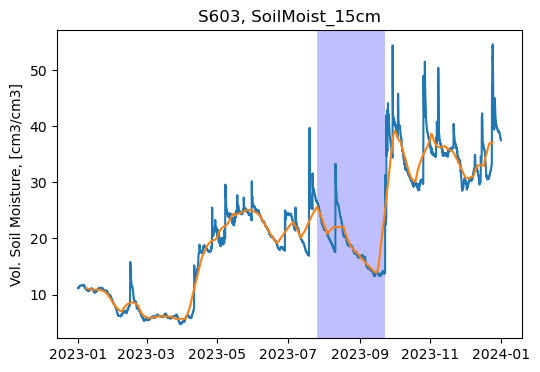

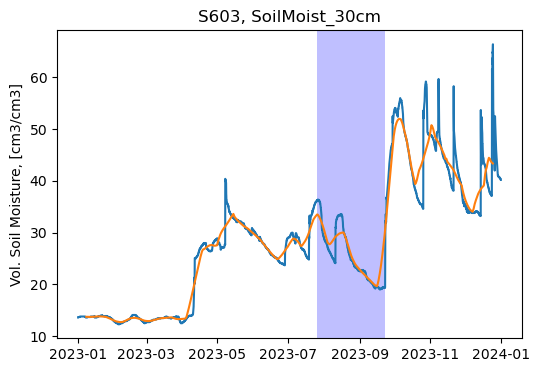

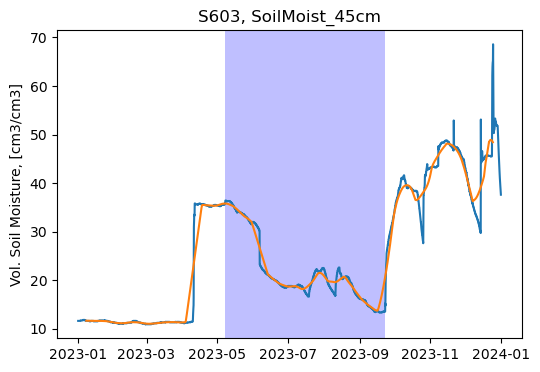

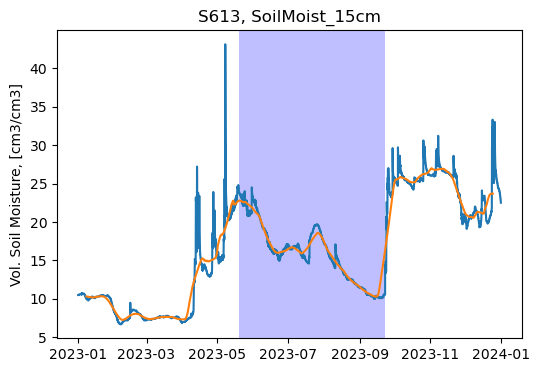

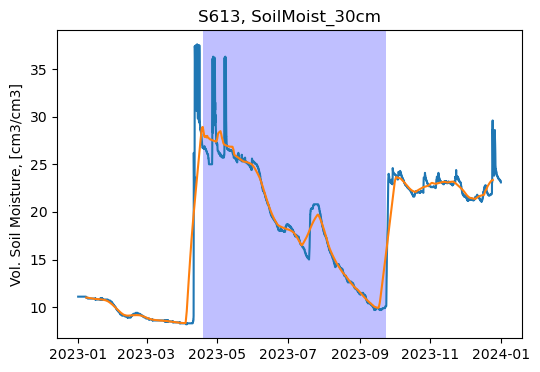

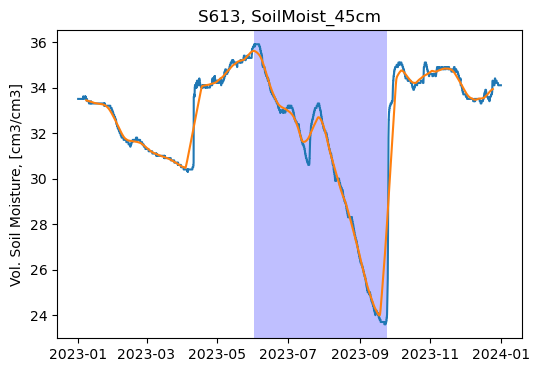

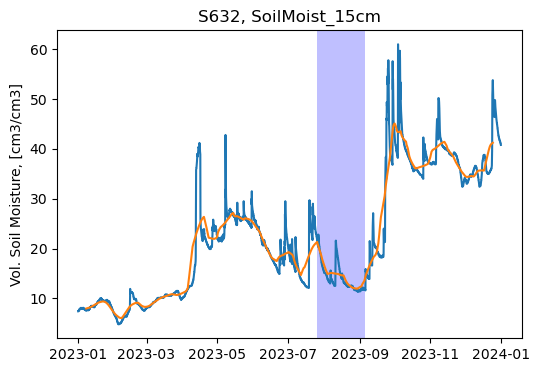

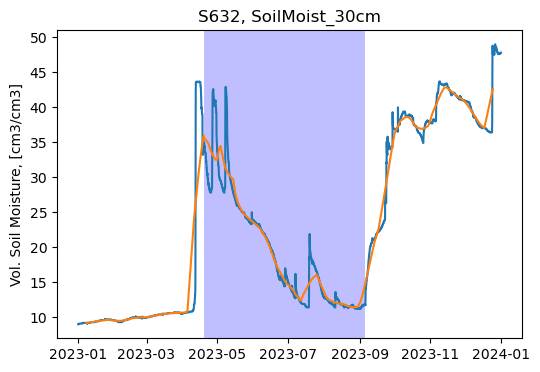

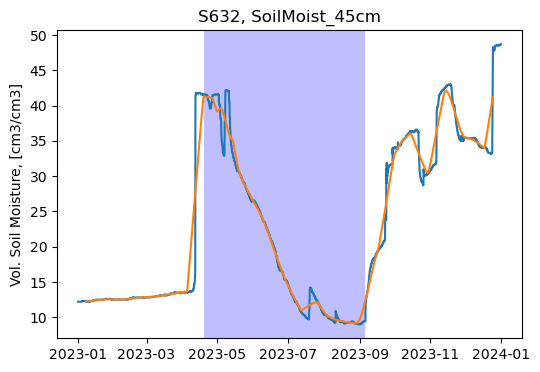

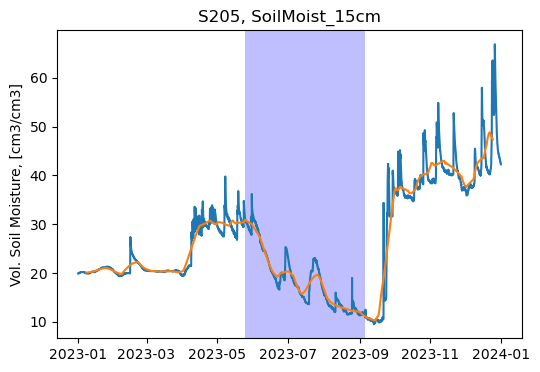

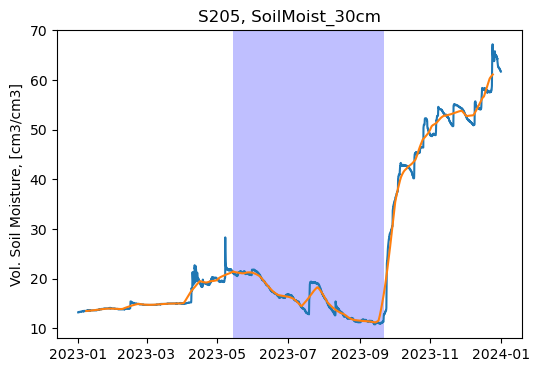

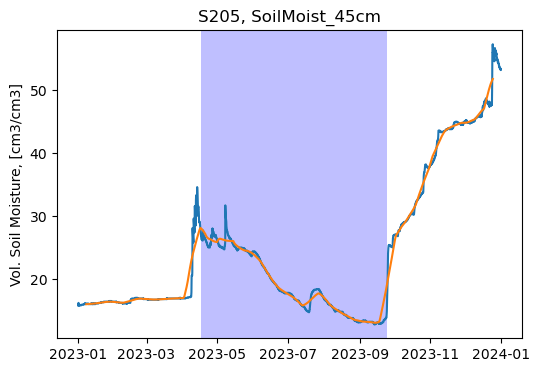

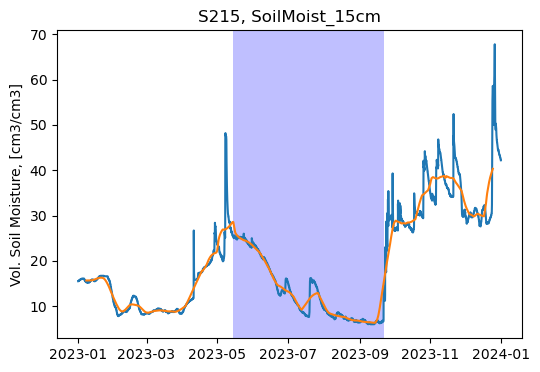

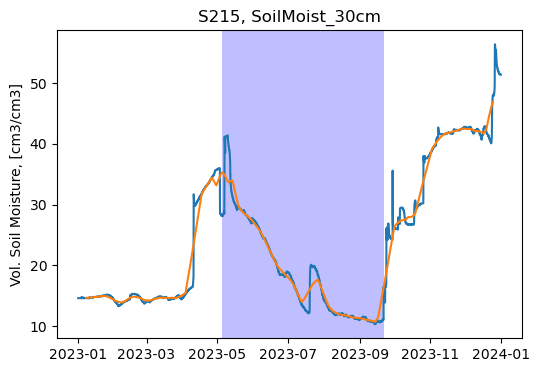

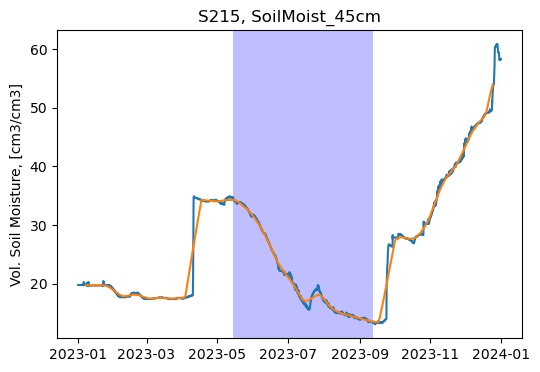

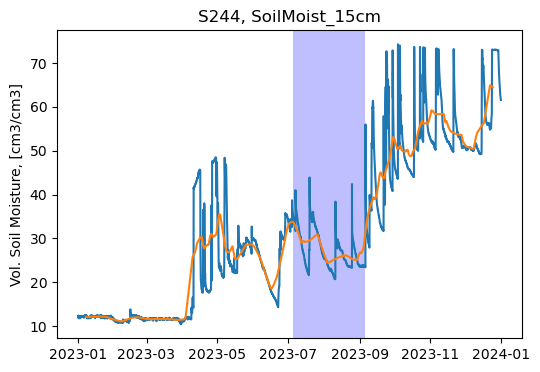

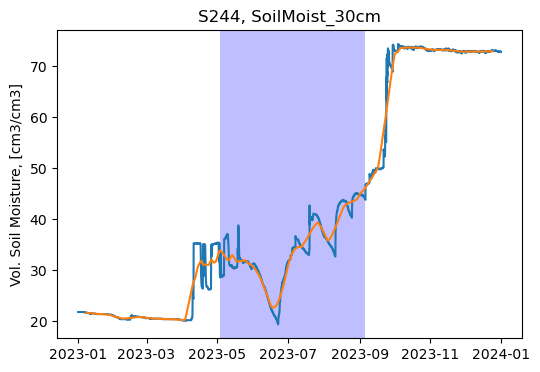

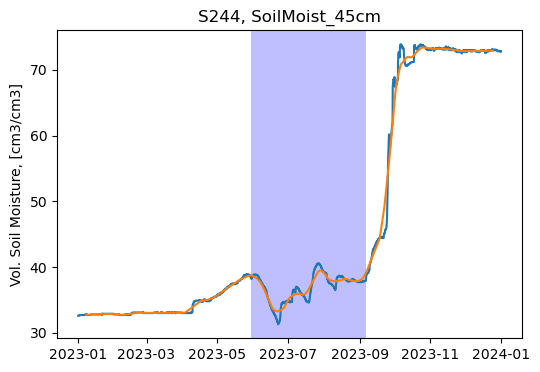

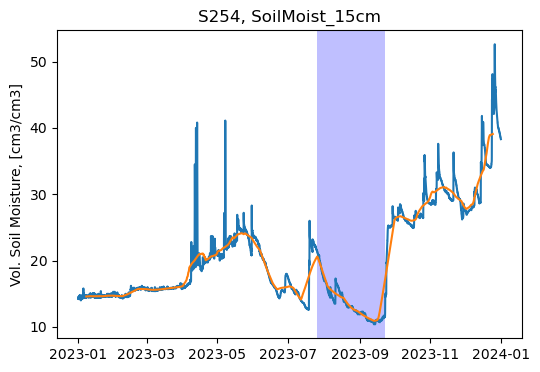

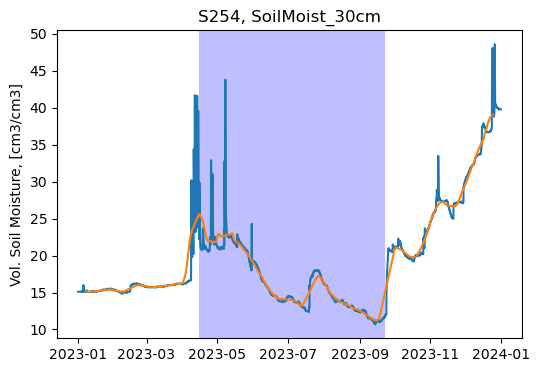

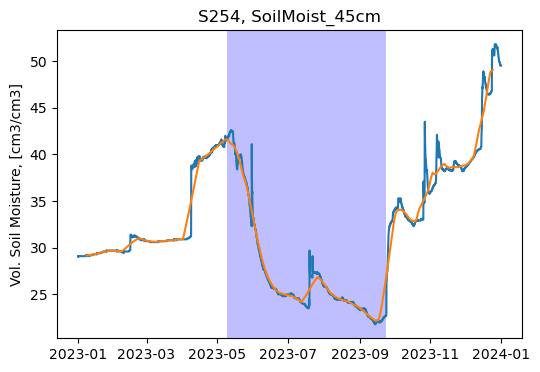

In [107]:
#Detect Soil Moisture Peaks and Throughs
drawdown_site = []
drawdow_depth = []
drawdown_begin = []
drawdown_end = []

for site in ['S603', 'S613', 'S632', 'S205', 'S215', 'S244', 'S254']:
    for col in ['SoilMoist_15cm', 'SoilMoist_30cm', 'SoilMoist_45cm']:
        #Prep data - 15cm moisture
        moistDat = soilM[(soilM.SensorName == site) & (soilM.DateTime.dt.year == 2023)][[col, 'DateTime']].reset_index(drop = True)
        moistDat['YEAR'] = moistDat.DateTime.dt.year
        moistDat['DOY'] = moistDat.DateTime.dt.day_of_year
        moistDat['moistDiff'] = np.diff(moistDat[col], prepend = [moistDat[col][0]])

        #Calculate 95th percentile of difference
        perc = np.percentile(abs(moistDat.moistDiff), 95)

        #Find the end of summer drawdown, start of fall monsoon
        #Plot
        #fig, ax = plt.subplots(1, 1, figsize = (6, 4))
        #ax.plot(moistDat.DateTime, moistDat.moistDiff)
        #ax.hlines(perc, min(moistDat['DateTime']), max(moistDat['DateTime']), color = 'orange')

        mask = np.where(((moistDat['moistDiff'] > perc) & (moistDat['DateTime'] > pd.to_datetime('09-01-2023'))), moistDat['moistDiff'], np.nan)
        fdrawdown = np.where(mask == findFirstNonZero(mask))[0][0]
        fdrawdown_date = moistDat['DateTime'][fdrawdown - 1] #mark day before

        #Find the beginning of summer drawdown, end of the spring melt season
        #Smoothe Data
        moistData_smooth = moistDat[col].rolling(24*14, center = True).mean() #two week rolling window
    
        peaks, _ = find_peaks(moistData_smooth, prominence = 5) 

        #fig, ax = plt.subplots(1, 1, figsize = (6, 4))
        #ax.plot(moistDat.DateTime, moistDat[col])
        #ax.plot(moistDat.DateTime, moistData_smooth)
        #ax.scatter(moistDat.DateTime[peaks], moistData_smooth[peaks], color = 'red', zorder = 3)
        #ax.set_ylabel('Vol. Soil Moisture, [cm3/cm3]')

        #Assign beginning of drawdown as last peak before September 1st (end index)
        bdrawdown_index = np.where(peaks < fdrawdown)[0][-1]
        bdrawdown = peaks[bdrawdown_index]
        bdrawdown_date = moistDat['DateTime'][bdrawdown] #mark day before

        #Plot
        fig, ax = plt.subplots(1, 1, figsize = (6, 4))
        ax.plot(moistDat.DateTime, moistDat[col])
        ax.plot(moistDat.DateTime, moistData_smooth)
        #ax.scatter(fdrawdown_date, moistDat[col][fdrawdown - 1], color = 'red', zorder = 3)
        #ax.scatter(bdrawdown_date, moistDat[col][bdrawdown], color = 'green', zorder = 3)
        ax.axvspan(fdrawdown_date, bdrawdown_date, color = 'b', alpha = 0.25, lw = 0)
        ax.set_ylabel('Vol. Soil Moisture, [cm3/cm3]')

        ax.set_title(site + ", " + col)

        #Save Data
        drawdown_site.append(site)
        drawdow_depth.append(col[-4:])
        drawdown_begin.append(bdrawdown_date)
        drawdown_end.append(fdrawdown_date)


In [132]:
#Combine Drawdown data
drawdown = pd.DataFrame({"Site" : drawdown_site, 
                        "Depth" : drawdow_depth,
                        "BeginDate" : drawdown_begin,
                        "EndDate" : drawdown_end})

drawdown['Length'] = [int(str(drawdown.EndDate[i] - drawdown.BeginDate[i])[0:3]) for i in range(0, len(drawdown))]

drawdown.head()

,Site,Depth,BeginDate,EndDate,Length
0,S603,15cm,2023-07-26 07:00:00,2023-09-23 00:00:00,58
1,S603,30cm,2023-07-26 08:00:00,2023-09-23 00:00:00,58
2,S603,45cm,2023-05-07 21:00:00,2023-09-23 01:00:00,138
3,S613,15cm,2023-05-20 01:00:00,2023-09-23 00:00:00,125
4,S613,30cm,2023-04-18 13:00:00,2023-09-24 01:00:00,158


In [133]:
#Save and Export data
drawdown.to_csv(import_path + 'soilMoisture_Drawdown.csv')

#### Stake Plots

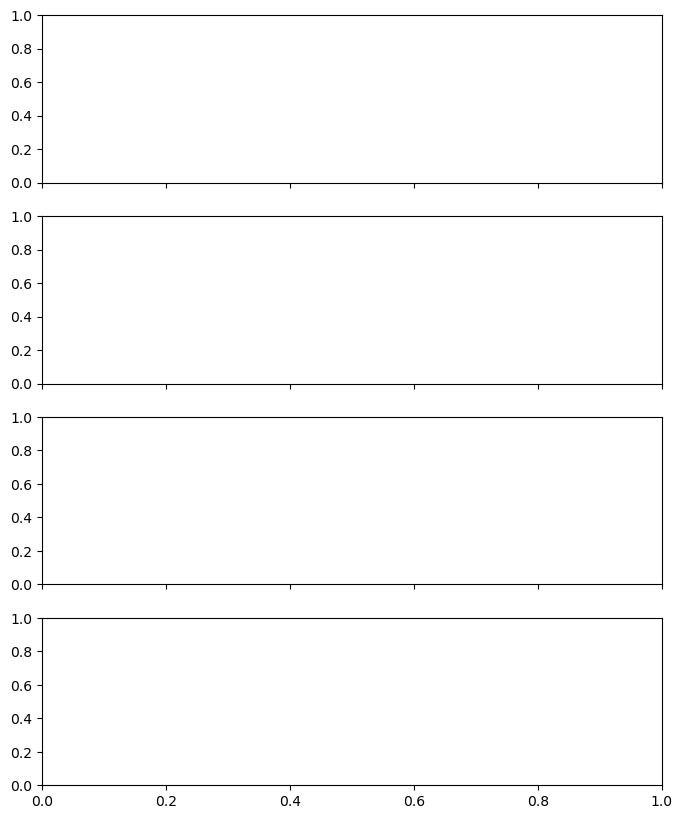

In [138]:
#Stacked S2 plots
fig, [ax1, ax2, ax3, ax4] = plt.subplots(4, 1, figsize = (8, 10), 
                                         sharey = True, 
                                         sharex = True)